# Chap 15 - Ex4: apply GMM to cluster data in pov_12.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

np.set_printoptions(suppress = True)
pd.set_option('display.width', 1000)

In [10]:
pov_12 = pd.read_csv('Data/pov_12.csv', sep = ' ', header=None)
pov_12.columns = ['Feature_1', 'Feature_2', 'Group']
pov_12

,Feature_1,Feature_2,Group
0,0.109393,0.085409,Cluster1
1,0.082571,0.101796,Cluster1
2,0.084990,0.113641,Cluster1
3,0.114611,0.115524,Cluster1
4,0.097356,0.095484,Cluster1
...,...,...,...
145,0.811963,0.668021,Cluster3
146,0.450739,0.631139,Cluster3
147,0.690514,0.732281,Cluster3
148,0.802583,0.472106,Cluster3


In [11]:
pov_12['Group'].value_counts()

Group
Cluster1    50
Cluster2    50
Cluster3    50
Name: count, dtype: int64

In [12]:
pov_12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Feature_1  150 non-null    float64
 1   Feature_2  150 non-null    float64
 2   Group      150 non-null    object 
dtypes: float64(2), object(1)
memory usage: 3.6+ KB


In [13]:
pov_12.describe()

,Feature_1,Feature_2
count,150.000000,150.000000
mean,0.356028,0.345022
std,0.253034,0.252320
min,0.053139,0.039897
25%,0.115626,0.113585
50%,0.302859,0.262653
75%,0.600826,0.563241
max,0.969061,0.985239


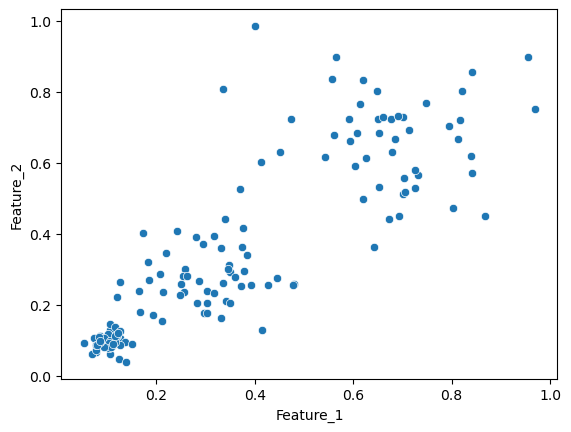

In [14]:
sbn.scatterplot(data = pov_12, x = 'Feature_1', y = 'Feature_2')
plt.show()

## <span style = 'color:yellow'> Check for normality and outliers

Shapiro test of Feature_1: ShapiroResult(statistic=0.8894037102839432, pvalue=3.4812228347239723e-09)
Shapiro test of Feature_2: ShapiroResult(statistic=0.8851894808142823, pvalue=2.093791115904985e-09)



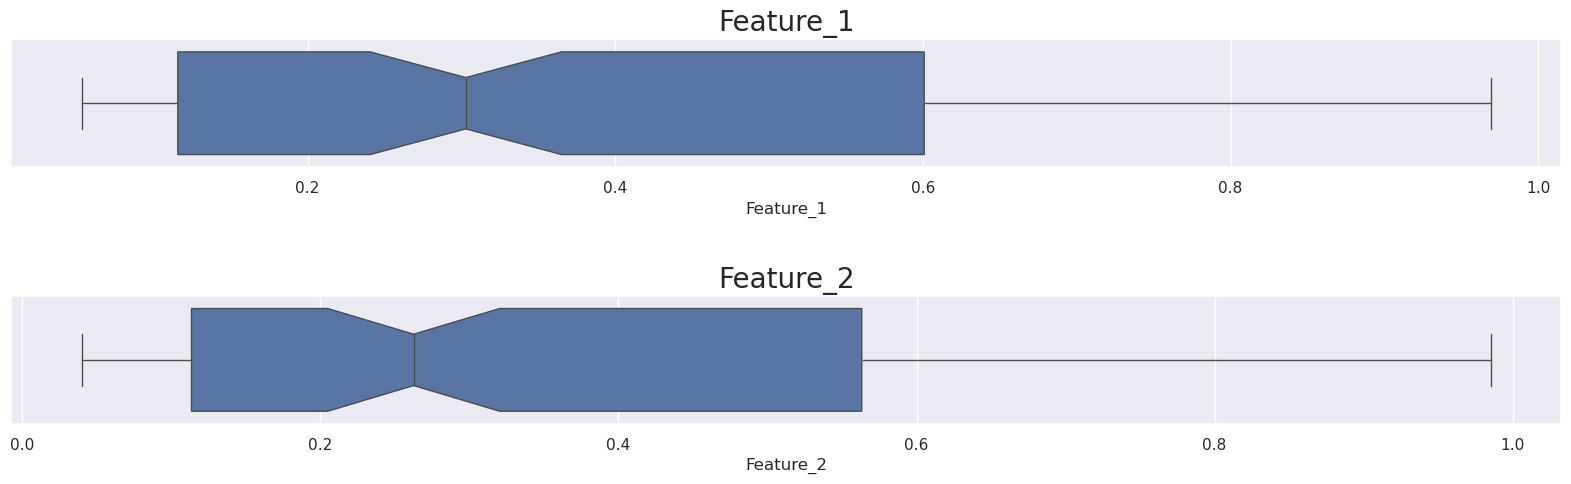

In [18]:
from scipy.stats import shapiro

data = pov_12.drop('Group', axis = 1)

for i in range(1, len(data.columns)+1):
    print(f'Shapiro test of {data.columns[i-1]}: {shapiro(data.iloc[:, i-1])}')
print()

sbn.set_theme(style='darkgrid')
plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2, hspace=1)
for i in range(1, len(data.columns)+1):
    try:
        plt.subplot(2, 1, i)
        sbn.boxplot(data = data, x = data.columns[i-1], notch = True)
        plt.title(data.columns[i-1], size = 20)
    except Exception:
        print('Error {}'.format(data.columns[i-1]))
        break
plt.show()

## <span style = 'color:yellow'> Both features are NOT normally distributed, have no outliers => can use MinMaxScaler
## <span style = 'color:yellow'> Use Silhoutte Score to find optimal K clusters

Silhouette score for k = 2: 0.6843842791883326
Silhouette score for k = 3: 0.612302224874367
Silhouette score for k = 4: 0.5264612092834589
Silhouette score for k = 5: 0.514356260749163
Silhouette score for k = 6: 0.5339000246793838
Silhouette score for k = 7: 0.47326528275939483
Silhouette score for k = 8: 0.45398393987055063
Silhouette score for k = 9: 0.42218553641909895


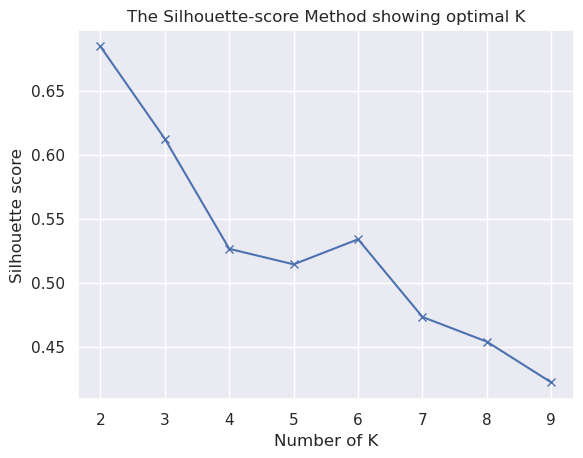

In [20]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import math

silh_score = []
k_nums = range(2,10)

data = pov_12.drop('Group', axis = 1)

for k in k_nums:
    gmm_pipe = Pipeline([
        ('MinMaxScaler', MinMaxScaler()),
        ('GMM', GaussianMixture(n_components = k, random_state = 1))
    ])
    gmm_pipe.fit(data)
    data_scaled = gmm_pipe[0].transform(data)
    labels = gmm_pipe.fit_predict(data)
    print(f'Silhouette score for k = {k}: {silhouette_score(data_scaled, labels)}')
    silh_score.append(silhouette_score(data_scaled, labels))



#Plot the Silhouette Score
plt.plot(k_nums, silh_score, 'bx-')
plt.xlabel('Number of K')
plt.ylabel('Silhouette score')
plt.title('The Silhouette-score Method showing optimal K')
plt.show()

     Feature_1  Feature_2  Group
0     0.109393   0.085409      0
1     0.082571   0.101796      0
2     0.084990   0.113641      0
3     0.114611   0.115524      0
4     0.097356   0.095484      0
..         ...        ...    ...
145   0.811963   0.668021      1
146   0.450739   0.631139      1
147   0.690514   0.732281      1
148   0.802583   0.472106      1
149   0.561666   0.677210      1

[150 rows x 3 columns]



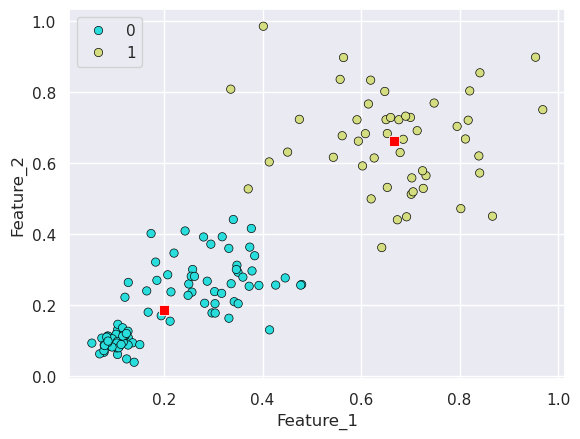

In [22]:
gmm_pipe = Pipeline([
    ('MinMaxScaler', MinMaxScaler()),
    ('GMM', GaussianMixture(n_components = 2))
])
gmm_pipe.fit(data)
labels = gmm_pipe.fit_predict(data)

data_group = (
    data.copy()
    .assign(Group = labels)
)

means_inverse = gmm_pipe.named_steps['MinMaxScaler'].inverse_transform(gmm_pipe.named_steps['GMM'].means_)

print(data_group)
print()

sbn.scatterplot(data = data_group, x = 'Feature_1', y = 'Feature_2', hue = 'Group', palette = 'rainbow', edgecolors = 'black')
sbn.scatterplot(x = means_inverse[:,0], y = means_inverse[:,1], color = 'red', marker = 's', s = 50)
plt.show()